In [ ]:
from ddpm_conditional import *
import pickle
# import torch_utils

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import dataset
import cv2
import matplotlib.pyplot as plt
img = cv2.imread("train/4/0.png", cv2.IMREAD_UNCHANGED)
img = dataset.add_fingerprint(img)
img[0:6, 0:6]

In [ ]:
from tqdm import tqdm
img_files = dataset.get_list_of_imgs("with_gain", "*.png")
imgs = [cv2.imread(x, cv2.IMREAD_UNCHANGED) for x in img_files]
for file, img in tqdm(zip(img_files, imgs)):
    img = dataset.add_fingerprint(img)
    cv2.imwrite(file, img)

In [ ]:
with open('models/edm-afhqv2-64x64-uncond-ve.pkl', 'rb') as f:
    ckpt = pickle.load(f)

In [ ]:

# Load the extracted weights into the corresponding layers of model2
# model2.load_state_dict(weights, strict=False)
for param_tensor in ckpt['ema'].state_dict():
    print(param_tensor, "\t", ckpt['ema'].state_dict()[param_tensor].size())

In [ ]:
print(ckpt['ema'].model.enc.parameters())

In [ ]:
import pickle
from ddpm_conditional import *
import torch.onnx

device = 'cuda:1'
batch_size = 1

torch_model = UNet_conditional(img_width=128, img_height=64, feat_num=3, device=device).to(device)
ckpt = torch.load("models/CFG_700_norm_fing/ema_ckpt.pt")
torch_model.load_state_dict(ckpt)
torch_model.eval()

x_t = torch.randn(batch_size, 1, 64, 128, requires_grad=True).to(device)
t = torch.randint(low=1, high=500, size=(batch_size,)).to(device)
settings = torch.randn(batch_size, 3, requires_grad=True).to(device)

# torch_out = torch_model(x_t, t, settings)

torch.onnx.export(torch_model,               # model being run
                  (x_t, t, settings),                         # model input (or a tuple for multiple inputs)
                  "diffAE.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=11,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['noised', 'timestep', 'settings'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}}
)

In [ ]:
import pickle
from ddpm_conditional import *
import torch.onnx

device = 'cuda:0'
batch_size = 1

with open('models/edm-afhqv2-64x64-uncond-ve.pkl', 'rb') as f:
    ckpt = pickle.load(f)
    torch_model = ckpt["ema"].to(device)
torch_model.eval()
batch_size = 1

x = torch.randn(batch_size, 3, 64, 64, requires_grad=False).to(device)
noise_labels = torch.randn(batch_size, 3, 64, 64, requires_grad=False).to(device)
class_labels = torch.randn(batch_size, 1, requires_grad=False).to(device)
torch_out = torch_model(x, noise_labels, class_labels)
summary(torch_model, noise_labels, class_labels)
# print(torch_out)
# for param_tensor in torch_model.state_dict():
#     print(param_tensor, "\t", torch_model.state_dict()[param_tensor].size())

# torch.onnx.export(torch_model,               # model being run
#                   (x, noise_labels, class_labels),                         # model input (or a tuple for multiple inputs)
#                   "edm.onnx",   # where to save the model (can be a file or file-like object)
#                   export_params=True,        # store the trained parameter weights inside the model file
#                   opset_version=9,          # the ONNX version to export the model to
#                   do_constant_folding=True,  # whether to execute constant folding for optimization
#                   input_names = ['im', 'noise', 'class'],   # the model's input names
#                   output_names = ['output'], # the model's output names
#                   dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
#                                 'output' : {0 : 'batch_size'}}
# )

# x_t = torch.randn(batch_size, 64, 128, requires_grad=True)
# t = torch.randn(batch_size, , requires_grad=True)
# settings = torch.randn(batch_size, 1, 64, 128, requires_grad=True)

# torch_out = ckpt(x_t, t, settings)


In [ ]:
import pandas as pd

def min_max_norm(col):
    return (col - col.min()) / (col.max() - col.min())

pd.read_csv("params.csv", engine='python')[["E","perc_N","P","gain","ms"]].apply(min_max_norm)

In [ ]:
import numpy as np
import torch

device = "cuda:2"
width = 128
height = 64
freqs_hor = np.pi*torch.linspace(0, width-1,width).to(device)/width
freqs_ver = np.pi*torch.linspace(0, height-1,height).to(device)/height
frequencies_squared = freqs_hor[:, None]**2 + freqs_ver[None, :]**2
frequencies_squared.shape

In [ ]:
import cv2
from matplotlib import pyplot as plt

im = cv2.imread("processed/6/26.png", cv2.IMREAD_UNCHANGED)
plt.imshow(im, vmin=0, vmax=255)

In [ ]:
im_res = cv2.resize(im, (128, 64))
im_res = cv2.resize(im_res, (512, 256))
plt.imshow(im_res, vmin=0, vmax=255)

In [ ]:
import dataset
deflection_MeV, spectrum_calibrated = dataset.get_1d(im/255, electron_pointing_pixel=62)

plt.title('Reconstructed Spectrum')
# print(spectrum_calibrated)
plt.plot(deflection_MeV, spectrum_calibrated)  # plot without fit
plt.ylabel('Spectral Intensity (pA/MeV)')
plt.xlabel('Energy (MeV)')
plt.xlim([2, 8])
# plt.ylim([0, 130])

In [ ]:
import dataset
deflection_MeV, spectrum_calibrated = dataset.get_1d(im_res/255, electron_pointing_pixel=62)

plt.title('Reconstructed Spectrum')
# print(spectrum_calibrated)
plt.plot(deflection_MeV, spectrum_calibrated)  # plot without fit
plt.ylabel('Spectral Intensity (pA/MeV)')
plt.xlabel('Energy (MeV)')
plt.xlim([2, 8])
# plt.ylim([0, 130])

In [ ]:
import cv2
from matplotlib import pyplot as plt
import dataset
import os
import numpy as np
def plot_average_image_pairs(root_folder, electron_pointing_pixel=62, noise=0.11):
    subfolders = sorted([f.path for f in os.scandir(root_folder) if f.is_dir()])
    n = len(subfolders)
    fig, axs = plt.subplots(n, 2, figsize=(15, 4*n))
    fig.subplots_adjust(hspace=0.35)  # Increase the space between rows
    fig.subplots_adjust(wspace=0.1)  # Decrease the space between columns
    for i, subfolder in enumerate(subfolders):
        images = []
        for filename in os.listdir(subfolder):
            if filename.endswith(".png"):
                im = cv2.imread(os.path.join(subfolder, filename), cv2.IMREAD_UNCHANGED)
                images.append(im)
        avg_im = np.mean(images, axis=0)
        deflection_MeV, spectrum_calibrated = dataset.get_1d(avg_im/255, electron_pointing_pixel=electron_pointing_pixel, noise=noise)

        axs[i, 1].plot(deflection_MeV, spectrum_calibrated)  # plot without fit
        axs[i, 1].set_title('Reconstructed Spectrum')
        axs[i, 1].set_ylabel('Spectral Intensity (pA/MeV)')
        axs[i, 1].set_xlabel('Energy (MeV)')
        axs[i, 1].set_xlim([2, 20])
        axs[i, 0].imshow(avg_im, vmin=0, vmax=255)
        axs[i, 0].set_title(os.path.basename(subfolder))
    plt.show()

In [ ]:
plot_average_image_pairs("processed", noise=0.11)

In [1]:
import cv2
from matplotlib import pyplot as plt
import dataset
import os
import numpy as np

In [2]:
def show_image_spectra(im, image_gain=0, noise=0.11, electron_pointing_pixel=62):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
    deflection_MeV, spectrum_calibrated = dataset.get_1d(im/255, electron_pointing_pixel=electron_pointing_pixel, image_gain=image_gain, noise=noise)

    ax2.plot(deflection_MeV, spectrum_calibrated)  # plot without fit
    ax2.set_title('Reconstructed Spectrum')
    ax2.set_ylabel('Spectral Intensity (pA/MeV)')
    ax2.set_xlabel('Energy (MeV)')
    ax2.set_xlim([2, 20])
    ax1.imshow(im, vmin=0, vmax=255)
    ax1.set_title("Image")
    plt.show()

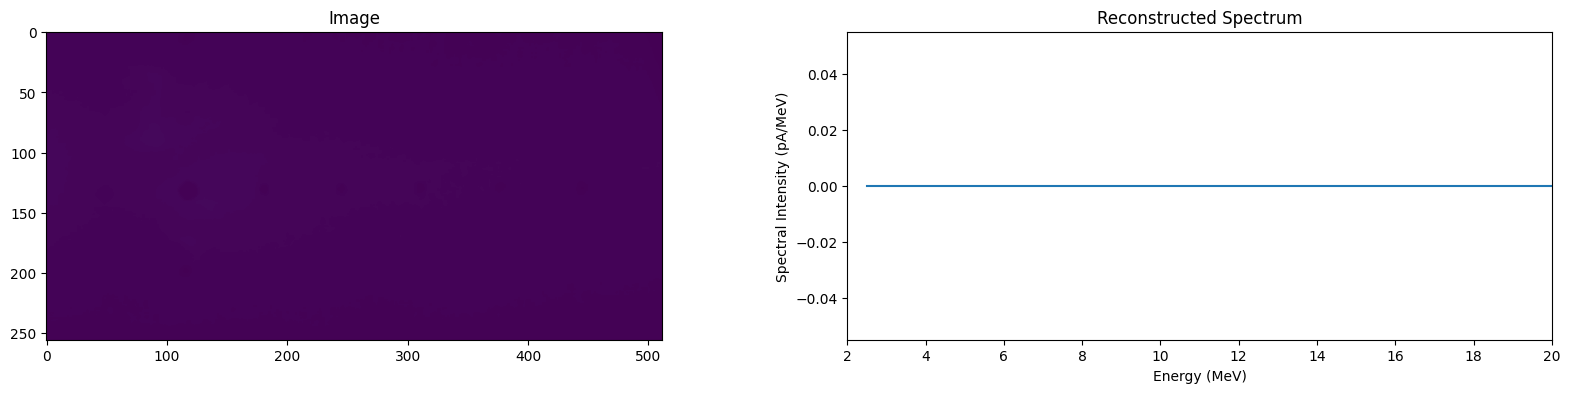

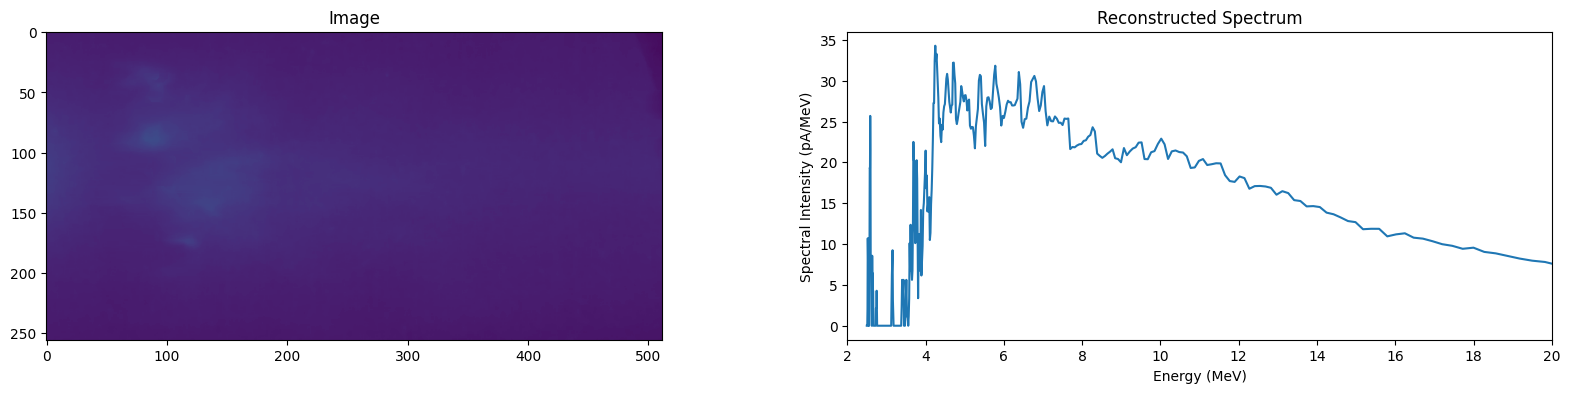

In [4]:
impath = "22/0.png"
my_gain = cv2.imread("processed/" + impath, cv2.IMREAD_UNCHANGED)
their_gain = cv2.imread("with_gain/" + impath, cv2.IMREAD_UNCHANGED)
noise = 0.11
show_image_spectra(my_gain, image_gain=0, noise=noise)
show_image_spectra(their_gain, image_gain=100, noise=noise)